## Imports and Environment Setup

This section imports all required libraries, sets up the environment variable for Python path, and imports necessary modules for image synthesis and evaluation.

In [10]:
from dataset import SiTDataset
from tqdm import tqdm
import os
os.environ['PYTHONPATH'] = '/env/python:/content/SiT'
import torch
from torchvision.utils import save_image
from transport import create_transport, Sampler
from diffusers.models import AutoencoderKL
from download import find_model
from models import SiT_S_2, SiT_B_8
import lpips
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from skimage.metrics import structural_similarity, mean_squared_error

## Helper Function: tensor_to_image

Converts a PyTorch tensor into a PIL image for visualization. This ensures the tensor values are in a valid range [0,1].

In [19]:
def tensor_to_image(tensor):
    tensor = tensor.detach().cpu()
    tensor = tensor.clamp(0, 1) 
    return TF.to_pil_image(tensor)

## Model and VAE Setup

Initializes the SiT model (Base-8) and loads pre-trained weights. Also loads the VAE (Variational Autoencoder) for encoding/decoding latent images.

In [5]:
image_size = "128"
vae_model = "stabilityai/sd-vae-ft-ema"
latent_size = int(image_size) // 8

model = SiT_B_8(input_size=latent_size, num_classes=1).to('cuda')
state_dict = find_model("results/000-SiT-B-8-Linear-velocity-None/checkpoints/0052500.pt")                # Print the actual tensor (can be large!)
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to('cuda')


/home/d/dziri/big/SiT/SiT/download.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_name, map_location=lambda storage, loc: storage)


## Sampling Configuration

Configures the sampler for generating images using either SDE or ODE approaches. Sets parameters for sampling steps, classifier-free guidance (CFG) scale, and sampler type.

In [6]:
#seed = 1 #@param {type:"number"}
#torch.manual_seed(seed)

num_sampling_steps = 250

cfg_scale = 4

class_labels = [0]
sampler_type = "ODE"

transport = create_transport()
sampler = Sampler(transport)

## Define the Sampling Function

Selects and configures the sampling method. Either Stochastic Differential Equation (SDE) or Ordinary Differential Equation (ODE) based sampling, with method-specific parameters.

In [7]:
# Sample images:
if sampler_type == "SDE":
    SDE_sampling_method = "Euler"
    diffusion_form = "linear"
    
    """This tells how strong the noise is"""
    diffusion_norm = 1
    
    """How the final denoised latent should be calculated"""
    last_step = "Mean"
    last_step_size = 0.4
    
    """Final function at the end that does everything:
    """
    sample_fn = sampler.sample_sde(
        sampling_method=SDE_sampling_method,
        diffusion_form=diffusion_form, 
        diffusion_norm=diffusion_norm,
        last_step_size=last_step_size, 
        num_steps=num_sampling_steps,
    )
elif sampler_type == "ODE":
    # default to Adaptive Solver
    ODE_sampling_method = "dopri5"

    atol = 1e-6
    rtol = 1e-3
    
    sample_fn = sampler.sample_ode(
        sampling_method=ODE_sampling_method,
        atol=atol,
        rtol=rtol,
        num_steps=num_sampling_steps
    )

## Dataset and Transformations

Sets up the dataset and the image preprocessing transformations. Loads the test split of the SiT dataset and normalizes images for use with the model.

In [8]:
from torchvision import transforms
from torch.utils.data import DataLoader

vae = AutoencoderKL.from_pretrained(vae_model).to("cuda")

device = 'cuda'

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1], inplace=True)
])

dataset = SiTDataset("data/chair_data/test", transform=transform)

ys = torch.zeros(1, dtype=torch.long, device="cuda")

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[[ 9.2386e-01,  4.1701e-01,  4.3438e-01,  ..., -1.2722e-01,
            1.6202e+00,  9.7215e-01],
          [ 2.1889e-01, -2.6424e-01, -2.3287e-01,  ...,  1.8145e+00,
            1.

## Random Image Pair Selection and Interpolation

Randomly selects two images and their poses from the dataset. Interpolates between their poses, synthesizes intermediate images using the sampling function, and displays the interpolation as a sequence of images.

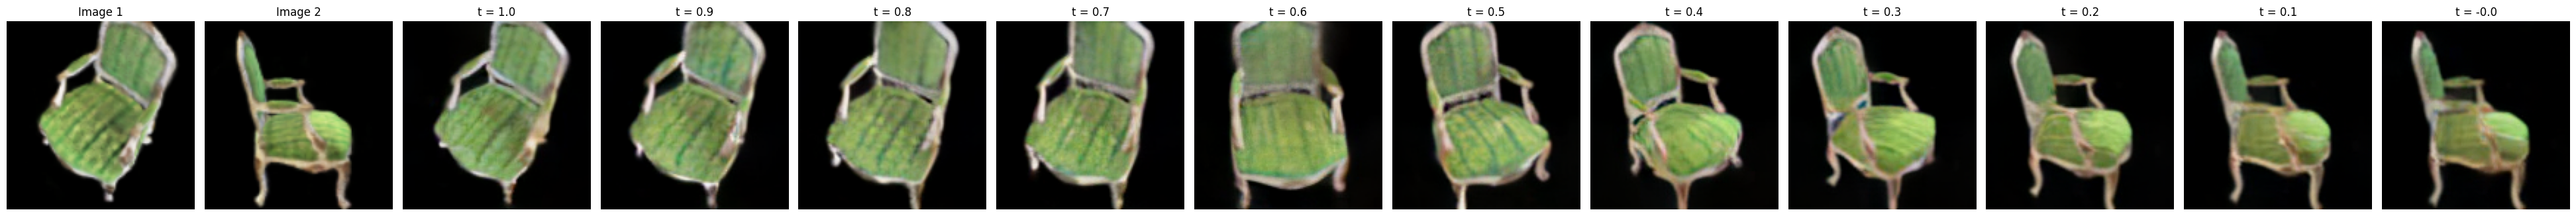

In [31]:
import torch
import matplotlib.pyplot as plt
import random

img_1_idx = random.randint(0, 1000)
img_2_idx = random.randint(0, 1000)

with torch.inference_mode():
    image_1, pose_1, _, _ = dataset.__getitem__(img_1_idx)
    image_2, pose_2, _, _ = dataset.__getitem__(img_2_idx)
    image_1, pose_1 = image_1.to("cuda"), pose_1.to("cuda")
    image_2, pose_2 = image_2.to("cuda"), pose_2.to("cuda")

    ts = torch.arange(1.0, -0.01, -0.1)
    n_images = len(ts) + 2
    fig, axes = plt.subplots(1, n_images, figsize=(3 * n_images, 4))

    img1_vis = tensor_to_image(image_1)
    img2_vis = tensor_to_image(image_2)
    axes[0].imshow(img1_vis)
    axes[0].set_title("Image 1")
    axes[0].axis("off")

    axes[1].imshow(img2_vis)
    axes[1].set_title("Image 2")
    axes[1].axis("off")

    for i, t in enumerate(ts):
        pose_interp = t * pose_1 + (1 - t) * pose_2
        z = torch.cat([pose_interp.unsqueeze(0), pose_interp.unsqueeze(0)], dim=0)
        y = torch.cat([torch.tensor([0], device="cuda"), torch.tensor([1] * ys.size(0), device="cuda")])
        samples = sample_fn(z, model.forward_with_cfg, y=y, cfg_scale=cfg_scale)[-1]
        sample = vae.decode(samples / 0.18215).sample[0]
        img_interp = tensor_to_image(sample)

        axes[i + 2].imshow(img_interp)
        axes[i + 2].set_title(f"t = {t:.1f}")
        axes[i + 2].axis("off")

    plt.tight_layout()
    plt.show()